# How to Tune Models like a Puppet-master Based on Confusion Matrix
## Learn to control model output based on what's important to the problem using a confusion matrix

![](./images/pixabay.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://pixabay.com/users/tskirde-3014515/?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=1594638'>Thomas Skirde</a>
        on 
        <a href='https://pixabay.com/?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=1594638'>Pixabay</a>
    </strong>
</figcaption>

### Setup

In [344]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams

rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
rcParams["figure.figsize"] = [12, 9]
rcParams["xtick.labelsize"] = 15
rcParams["ytick.labelsize"] = 15
rcParams["font.size"] = 15
warnings.filterwarnings("ignore")

### Introduction

Classification is a huge part of machine learning. Its benefits and applications are endless - ranging from detecting new asteroids and planets to identifying cancerous cells are all done using classification algorithms. 

The type of the problems classification solves is divided into two: unsupervised and supervised. Unsupervised models are called neural networks and they can be trained on unstructured data such as video, audio and images. In contrast, supervised models work with labeled, tabular data and is part of classic machine learning. The focus of this article is the latter, particularly, we will be exploring what all supervised classification problems have in common: *confusion matrices*.

### Developing a Classification Preprocessing Pipeline

A good model needs good data. So, it is important to process the available information as much as possible to achieve best model performance even before tuning it based on confusion matrices. 

A typical preprocessing workflow includes dealing with missing values, scaling/normalizing numeric features, encoding categorical variables and do all other feature engineering steps required. We will see an example of this in this section.

We will be predicting credit card approvals using the [Credit Card Approval Dataset](http://archive.ics.uci.edu/ml/datasets/credit+approval) from UCI Machine Learning Repository. Before banks can issue credit cards to new customers, there are many factors to consider: income levels, loan balances, individual's credit report, etc. This is often a difficult and mundane task, so nowadays banks use ML algorithms. Let's take a peek at the data:

In [357]:
import pandas as pd

df = pd.read_csv("data/cc_approvals.data", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


Since it is private data, the feature names are left blank. Let's fix that first:

In [358]:
df.columns = ["feature_" + str(col) for col in df.columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature_0   690 non-null    object 
 1   feature_1   690 non-null    object 
 2   feature_2   690 non-null    float64
 3   feature_3   690 non-null    object 
 4   feature_4   690 non-null    object 
 5   feature_5   690 non-null    object 
 6   feature_6   690 non-null    object 
 7   feature_7   690 non-null    float64
 8   feature_8   690 non-null    object 
 9   feature_9   690 non-null    object 
 10  feature_10  690 non-null    int64  
 11  feature_11  690 non-null    object 
 12  feature_12  690 non-null    object 
 13  feature_13  690 non-null    object 
 14  feature_14  690 non-null    int64  
 15  feature_15  690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


The dataset contains both numeric and categorical features. The missing values in this dataset are encoded with question marks (?). We will replace them with `NaN`s:

In [359]:
import numpy as np

df = df.replace("?", np.nan).copy()

df.isnull().sum()

feature_0     12
feature_1     12
feature_2      0
feature_3      6
feature_4      6
feature_5      9
feature_6      9
feature_7      0
feature_8      0
feature_9      0
feature_10     0
feature_11     0
feature_12     0
feature_13    13
feature_14     0
feature_15     0
dtype: int64

Features 0, 1, 3, 4, 5, 6 and 13 contain missing values. Inspecting the data, we may guess that feature 13 contains zipcodes, so we can drop it. And for others, since they make up less than the 5% of the dataset, we can drop those rows:

In [360]:
# Drop zipcode col
df.drop("feature_13", axis=1, inplace=True)

# Drop rows with NaNs
df.dropna(how="any", inplace=True)

df.shape

(659, 15)

We did not use any imputation techniques because of the low number of nulls. If you want to know about robust imputation techniques, this article will help:

https://towardsdatascience.com/going-beyond-the-simpleimputer-for-missing-data-imputation-dd8ba168d505?source=your_stories_page-------------------------------------

Let's focus on numeric values now. Specifically, we will look at their distributions:

In [361]:
df.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
feature_2,659.0,4.852,5.020,0.0,1.040,2.875,7.520,28.0
feature_7,659.0,2.251,3.383,0.0,0.165,1.000,2.625,28.5
feature_10,659.0,2.499,4.952,0.0,0.000,0.000,3.000,67.0
feature_14,659.0,1046.024,5324.983,0.0,0.000,5.000,400.000,100000.0


All features have a minimum of 0 but they are all on different scales. This means we have to use some type of normalization and we will see what kind by exploring these features visually:

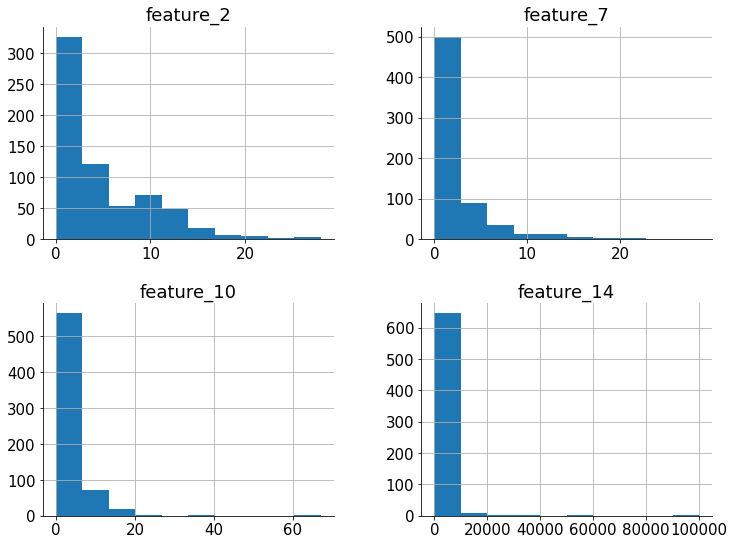

In [362]:
import seaborn as sns

df.hist();

Features have skewed distributions which means, we will perform non-linear transform such as `PowerTransformer` (uses logarithms under the hood):

In [363]:
# Store the cols to be log transformed
to_log = df.select_dtypes(include="number").columns.to_list()
to_log

['feature_2', 'feature_7', 'feature_10', 'feature_14']

If you want to know more about other numeric feature transformation techniques, I got that covered too:
https://towardsdatascience.com/how-to-differentiate-between-scaling-normalization-and-log-transformations-69873d365a94?source=your_stories_page-------------------------------------

To encode categorical features, we will use a `OneHotEncoder`. Before isolating the columns to be used in encoding, let's separate the data into feature and target arrays:

In [364]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]  # the last column is the target

Now, isolate the categorical columns to be OH encoded:

In [365]:
categorical_cols = X.select_dtypes(include="object").columns.to_list()

Finally, we will build the preprocessing pipeline:

> If you are not familiar with Sklearn pipelines and column transformers, I recommend reading this post:
https://towardsdatascience.com/how-to-use-sklearn-pipelines-for-ridiculously-neat-code-a61ab66ca90d

In [366]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PowerTransformer

# Create a col_transformer object
col_transformer = ColumnTransformer(
    transformers=[
        ("log", PowerTransformer(), to_log),
        (
            "oh_encode",
            OneHotEncoder(sparse=False, handle_unknown="ignore"),
            categorical_cols,
        ),
    ]
)

# Combine into a final pipeline
pipeline = Pipeline(
    steps=[("preprocess", col_transformer), ("base_model", RandomForestClassifier())]
)

# Encode the target manually to encode the positive class
y = y.map({"+": 1, "-": 0})

### Intro to the Confusion Matrix

At the last step, I added a `RandomForestClassifier` to the pipeline as a base model. We want the model to predict approved applications more accurately because that would mean more customers to the bank. This would also make the approved applications a *positive class* in our predictions. Let's finally evaluate the pipeline:

In [292]:
from sklearn.model_selection import train_test_split

# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

# Fit/score the pipeline
pipeline.fit(X_train, y_train)
print(f"RandomForest pipeline scored {pipeline.score(X_test, y_test).round(3)}")

RandomForest pipeline scored 0.874


The default scoring of all classifiers is the accuracy score, which our base pipeline impressively achieved ~89%. 

But, here is the problem with accuracy - what is the model *accurate* at? Can it predict suitable applications better or is it more accurate at detecting undesirable candidates? From a business perspective, your results should be able to answer both questions and accuracy does not do that. 

As a solution, let's finally get introduced to a confusion matrix:

In [293]:
from sklearn.metrics import confusion_matrix

# Generate predictions
y_pred = pipeline.predict(X_test)

# Create the confusion matrix
confusion_matrix(y_test, y_pred)

array([[95, 13],
       [12, 78]], dtype=int64)

Since, it is a binary classification problem, the matrix is of shape 2 by 2 (there are two classes in the target). The diagonal of the matrix shows the number of correctly classified samples and the off-diagonal cells shows where the model made a mistake. To further understand this, Sklearn provides a visual matrix, which is much better:

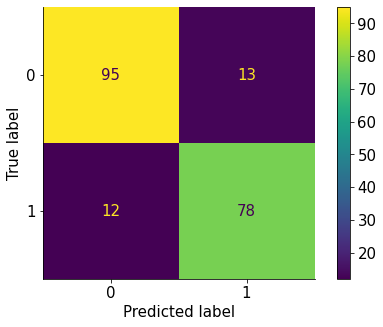

In [294]:
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(8, 5))
plot_confusion_matrix(
    pipeline,  # Fitted estimator (it must have been fit)
    X_test,
    y_test,  # test sets
    ax=ax,
);

This confusion matrix is much more informative. Here are a few things to notice:
- The rows correspond to the actual values 
- The columns correspond to the predicted values
- Each cell is a count of each true/predicted value combination

Paying attention to the axes labels, the first row represents the actual negative class (rejected applications) while second row is for the actual positive (approved applications) class. Similarly, the first column is for the positive predicted and the second for negative predicted. 

Before we go on to interpreting this output, let's fix the format of this matrix. In many other literature, you will see that the actual positive class represented as the first row and the predicted positive class as the first column. I am also used to that format and find it easier to explain.

We will flip the matrix so that the first row and column is the positive class. We will also use Sklearn's `ConfusionMatrixDisplay` function that plots custom matrices. Here is a wrapper function:

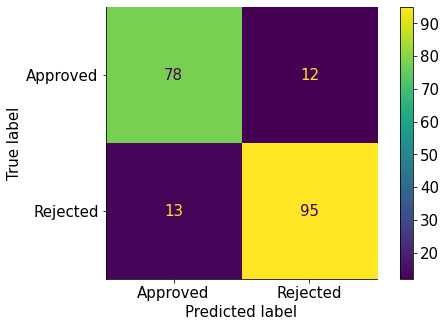

In [313]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay


def custom_confusion_matrix(y_true, y_pred, display_labels=None):
    """
    A function to plot a custom confusion matrix with
    positive class as the first row and the first column.
    """
    # Create a flipped matrix
    cm = np.flip(confusion_matrix(y_true, y_pred))
    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(cm, display_labels=display_labels)
    cmp.plot(ax=ax)


custom_confusion_matrix(y_test, y_pred, display_labels=["Approved", "Rejected"])

We are flipping the matrix using `np.flip` and plotting it via `ConfusionDisplayFunction` which only takes a matrix and accepts custom class labels through `display_labels` parameter.

Let's finally interpret this matrix:

- **(top left)** - there were 78 applications which were actually *approved* and the model *correctly* classified them *approved* as well
- **(bottom right)** - there were 95 applications which were actually *rejected* and the model *correctly* classified them *rejected* as well
- **(bottom left)** - there were 13 applications which were actually *rejected* but the model *incorrectly* classified them as *approved*
- **(top right)** - there were 12 applications which were actually *approved* but the model *incorrectly* classified them as *rejected*.


Because of the popularity of confusion matrices, each true/predicted cell combination has their own name in the community:

- **True Positives (TP)** - actual positive, predicted positive (top left, 78)
- **True Negatives (TN)** - actual negative, predicted negative (bottom right, 95)
- **False Positives (FP)** - actual negative, predicted positive (bottom left, 13)
- **False Negatives (FN)** - actual positive, predicted negative (top right, 12)

Even though you may see a matrix in a different format, the above 4 terms will always be there. That's why before creating a model, it is useful to create a mental note of what the above 4 terms refer to in your unique case.

After you fit a model, you can extract each of the above 4 using the `.ravel()` method on a confusion matrix:

In [315]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(95, 13, 12, 78)

### Precision, Recall and F scores

In this section, we will learn about further metrics that lets us compare one confusion matrix to another. Let's say we have another pipeline with `LogisticRegression` as a classifier:

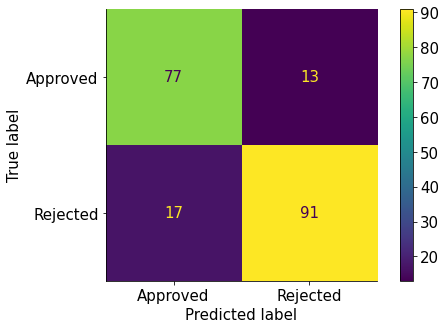

In [320]:
from copy import deepcopy

from sklearn.linear_model import LogisticRegression

# Copy the pipeline to edit the estimator
logreg_pipeline = deepcopy(pipeline)
logreg_pipeline.steps[1] = ("base_model", LogisticRegression())

# Fit/predict the logreg pipeline
logreg_pipeline.fit(X_train, y_train)
y_pred_logistic = logreg_pipeline.predict(X_test)

# Plot the confusion matrix
custom_confusion_matrix(
    y_test, y_pred_logistic, display_labels=["Approved", "Rejected"]
)

### ADD THE FIRST MATIX FOR COMPARISON

Looking at the plots above, we might say the results of both Random Forests and Logistic Regression are similar. However, there are 3 common metrics we can derive from the confusion matrix that lets us compare them. These are called *precision*, *recall* and *F1 score*. Let's understand each one in detail:

1. **Precision**: it is the ratio of the number of correctly classified positives and the total number of predicted positive classes. In our case, it is the total number of correctly classified, *approved applications* (TP = 77) divided by the total number of predicted approved classifications (all predicted positives, regardless of whether they are correct or not, TP + FP = 94). Using the matrix terms, it is:
![](images/precision.png)

You can easily remember this with *Triple-P* rule - precision involves all positives and uses the terms in the left side of the matrix.

Sklearn's official definition of precision is: "the ability of the classifier not to label a negative sample as positive". In our case, it is the ability of our model not to label *rejected applications* as approved. So, if we want the model to be more accurate at filtering unsuitable applications, we should optimize for precision. In other words, increase True Positives and decrease False Positives as much as possible. 0 False Positives gives a precision of 1.

2. **Recall**: also called *sensitivity, hit rate* or *true positive rate (TPR)*. It is the ratio of correctly classified positives divided by the total number of actual positives in the target. In our case, it is the number of correctly classified, *approved applications* (TP = 77) divided by the total number of *actual approved applications* (regardless of whether they were correctly predicted or not, TP + FN = 90). Using the terms of confusion matrix:
![](images/recall.png)

Recall uses the terms in the first row of the confusion matrix.

Sklearn's official definition for recall is: "the ability of the classifier to find all the positive samples". If we optimize for recall, we will be trying to decrease the number of False Negatives (incorrectly classified, approved applications) and increase the number of True Positives. But this may be at the cost of increasing False Positives - i. e. incorrectly classifying rejected applications as approved.

Due to their nature, Precision and Recall is in a trade-off relationship. Depending on your business problem, you may have to focus on optimizing one at the cost of the other. However, what if you wanted to have a balanced model - i.e., a model that is equally good at detecting the positives and the negatives.

In our case, this would make sense - a bank would benefit the most if it could find as many customers as possible while also avoiding undesirable candidates, thus eliminating potential loss. 

3. The third metric, called the *F1 score*, tries to measure exactly that: it quantifies the model's ability of predicting both classes correctly. It is calculated by taking the harmonic mean of precision and recall:

![](images/f1.png)

Why the harmonic mean you ask? Because of how it is calculated, the harmonic mean truly gives a balanced score. If either precision or recall have a low value, the F1 score suffers significantly. This is a useful mathematical property compared to the simple mean.

All these metrics can be calculated using Sklearn and they are available under the `metrics` submodule:

In [322]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Compute precision for the two pipelines
print("Precision of RandomForests: {}".format(precision_score(y_test, y_pred)))
print(
    "Precision of LogisticRegression: {}".format(
        precision_score(y_test, y_pred_logistic)
    )
)

Precision of RandomForests: 0.8571428571428571
Precision of LogisticRegression: 0.8191489361702128


RandomForest has a greater precision indicating that it is better at finding approvable applications while lowering false positives, i. e. incorrectly classified undesirable candidates.

In [323]:
# Compute recall for the two pipelines
print("Recall of RandomForests: {}".format(recall_score(y_test, y_pred)))
print("Recall of LogisticRegression: {}".format(recall_score(y_test, y_pred_logistic)))

Recall of RandomForests: 0.8666666666666667
Recall of LogisticRegression: 0.8555555555555555


RandomForests wins in recall too. It is similarly better at filtering out false negatives, i. e., decreasing the number of positive samples classified as negative. Since, RandomForests won in both scores, we can expect it to have higher F1 too:

In [324]:
# Compute recall for the two pipelines
print("F1 of RandomForests: {}".format(f1_score(y_test, y_pred)))
print("F1 of LogisticRegression: {}".format(f1_score(y_test, y_pred_logistic)))

F1 of RandomForests: 0.861878453038674
F1 of LogisticRegression: 0.8369565217391304


As expected, RF has a higher F1 making it a more robust model for our case.

You can print out all these scores at once using the `classification_report` function:

In [377]:
from sklearn.metrics import classification_report

# Classification report for LogReg
print(classification_report(y_test, y_pred_logistic))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       108
           1       0.82      0.86      0.84        90

    accuracy                           0.85       198
   macro avg       0.85      0.85      0.85       198
weighted avg       0.85      0.85      0.85       198



Before we go on to focusing on optimizing for these metrics, let's take a look at other scenarios to deepen our understanding.

### More practice on interpreting precision, recall and F1

Since the differences between these metrics is subtle, you need some practice to develop a strong intuition for them. In this section, we will do just that!

Let's say we are trying to detect whether parachutes sold in the sky-diving shop are faulty or not. The assistance examines all available parachutes and records their attributes and classifies them. We want to automate this process and build a model that should be exceptionally good at detecting faulty parachutes. 

For example purposes, we will create the dataset synthetically:

In [327]:
from sklearn.datasets import make_classification

X_ex1, y_ex1 = make_classification(
    n_samples=500, n_features=5, n_informative=4, n_redundant=1, weights=[0.9, 0.1]
)

Since there are much more working parachutes, it is an inbalanced classification problem. Let's set up the terminology:

- The positive class: faulty parachutes
- The negative class: working parachutes
- True positives: faulty parachutes predicted correctly
- True negatives: working parachutes predicted correctly
- False positives: faulty parachutes predicted incorrectly
- False negatives: working parachutes predicted incorrectly

Let's evaluate a Random Forest model on this data:

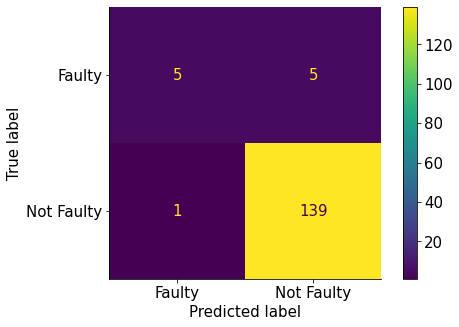

In [333]:
X_train_ex1, X_test_ex1, y_train_ex1, y_test_ex1 = train_test_split(
    X_ex1, y_ex1, test_size=0.3, random_state=1121218
)

forest = RandomForestClassifier()
forest.fit(X_train_ex1, y_train_ex1)
y_pred_ex1 = forest.predict(X_test_ex1)

custom_confusion_matrix(y_test_ex1, y_pred_ex1, display_labels=["Faulty", "Not Faulty"])

In this problem, we should try to lower the top right (False Negatives) as much as possible because even one faulty parachute means a death of a skydiver. Looking at the scorings, we should be optimizing the recall score:

![](images/recall.png)

It is perfectly OK if False positives increase, because we will be saving people's lives even though we might lose some money.

In the second scenario, we will try to predict customer churn (stop or continue using our company's services). Again, let's set up the terminology for the problem:

- Positive class: continue using
- Negative class: churn
- True positives: wants to continue, predicted correctly
- True negatives: churn, predicted correctly
- False positives: churn, predicted incorrectly
- False negatives: wants to continue, predicted incorrectly

We will build a synthetic dataset again and evaluate RF on it:

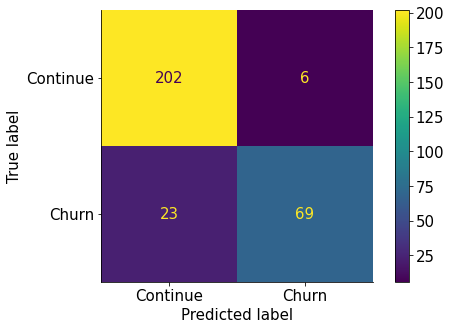

In [342]:
X_ex2, y_ex2 = make_classification(
    n_samples=1000, n_features=7, n_informative=5, n_redundant=2, weights=[0.7, 0.3]
)

X_train_ex2, X_test_ex2, y_train_ex2, y_test_ex2 = train_test_split(
    X_ex2, y_ex2, test_size=0.3, random_state=1121218
)

forest = RandomForestClassifier()
forest.fit(X_train_ex2, y_train_ex2)
y_pred_ex2 = forest.predict(X_test_ex2)

fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test_ex2, y_pred_ex2), display_labels=["Continue", "Churn"]
)
cmp.plot(ax=ax);

In this case, we want to retain as much customers as possible. This means we have to lower False Positives indicating that we should optimize precision:

![](images/precision.png)

In this article, we only focused on 3 metrics. However, there are many other scores you can derive from the confusion matrix such as specificity, NPV, FNR, etc. After reading this article, you should be able to read the [Wikipedia page](https://en.wikipedia.org/wiki/Confusion_matrix) on the topic. If you find yourself confused about the metrics themselves, check out this [awesome article](https://medium.com/swlh/how-to-remember-all-these-classification-concepts-forever-761c065be33) too.

Finally, let's see how to optimize for each of the metrics we discussed today.

### Optimizing models for a particular metric using HalvingGridSearchCV

In this section, we will see how to boost a model's performance for a metric of our choice. In the above sections, we used models with default parameters. To increase their performance, we have to do hyperparameter tuning, specifically, we should find the set of hyperparameters that gives the highest score for our desired metric. 

Searching for this magical set is tedious and time-consuming. So we will bring out the `HalvingRandomSearchCV` class which searches over a grid of possible parameters for the model and find the set that gives highest score for the scoring function passed to its `scoring` parameter. 

> You might be surprised that I am not using GridSearch. In one of my articles I showed how Halving Grid Search is 11 times faster than regular GridSearch. And Halving Grid Search is even faster, allowing us to widen our hyperparameter space to a great extent. You can read the comparison here:

https://towardsdatascience.com/11-times-faster-hyperparameter-tuning-with-halvinggridsearch-232ed0160155

As a first step, we will build the hyperparameter space:

In [373]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ["auto", "sqrt"]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)] + [None]
min_samples_split = [2, 5, 7, 10]
min_samples_leaf = [1, 2, 3, 4]
bootstrap = [True, False]

param_grid = {
    "base_model__n_estimators": n_estimators,
    "base_model__max_features": max_features,
    "base_model__max_depth": max_depth,
    "base_model__min_samples_split": min_samples_split,
    "base_model__min_samples_leaf": min_samples_leaf,
    "base_model__bootstrap": bootstrap,
}

Now, we will search over this grid 3 times optimizing for each of the metrics we discussed today:

In [375]:
%%time

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

metrics = ["precision", "recall", "f1"]
best_params = dict()

for metric in metrics:
    # Init the grid
    search = HalvingRandomSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        cv=5,
        scoring=metric,
        random_state=1121218,
        n_candidates="exhaust",
        factor=3,
        n_jobs=-1,
    )

    # Fit to the full data
    _ = search.fit(X, y)
    print(f"Best score for {metric} is {search.best_score_}")

    best_params[metric] = search.best_params_
    print("Saved the best params for this metric...")

Best score for precision is 0.883536231884058
Saved the best params for this metric...
Best score for recall is 0.8446455505279035
Saved the best params for this metric...
Best score for f1 is 0.835454919599024
Saved the best params for this metric...
Wall time: 10min 45s


We managed to score higher in terms of precision but got a lower score for recall and F1. It is an iterative process, so you can continue the search until the scores improve. Or if you have time, you can change to HalvingGridSearch which is much slower than HalvingRandomSearch but gives much better results.

### Summary

The hardest part of any classification problem is truly understanding the business problem you are trying to solve and optimize for a metric accordingly. Once you theoretically construct the appropriate confusion matrix and its terms, there is only the coding part left. 

In terms of coding, having a good preprocessing pipeline ensures that you have the best score possible for a base model of your choice. Make sure to scale/normalize the data based on the underlying distributions. After preprocessing, create copies of your pipeline for multiple classifiers. LogisticRegression, Random Forests, KNN Classifier are good choices.

For optimization, choose either Halving Grid or Halving Random Search. They have been proven to be much better than their previous counterparts. Thanks for reading!

### Further reading ...
- [Confusion matrix Sklearn user guide](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)
- [StatQuest on Confusion Matrix](https://www.youtube.com/watch?v=Kdsp6soqA7o&t=3s)
- [StatQuest on Sensitivity and Specificity](https://www.youtube.com/watch?v=vP06aMoz4v8)
- [Optimising a Machine Learning Model with the Confusion Matrix](https://towardsdatascience.com/understanding-the-confusion-matrix-and-its-business-applications-c4e8aaf37f42)

### You might also be interested
- [Going Beyond the SimpleImputer For Missing Data Imputation](https://towardsdatascience.com/going-beyond-the-simpleimputer-for-missing-data-imputation-dd8ba168d505?source=your_stories_page-------------------------------------)
- [How to Perform Operator Overloading in Python OOP](https://codecrunch.org/operator-overloading-in-python-oop-fun-tutorial-1a8a867023ac?source=your_stories_page-------------------------------------)
- [Practical Sklearn Feature Selection in 3 stages](https://towardsdatascience.com/4-part-practical-study-guide-to-sklearn-feature-selection-b959a28d9ef7?source=your_stories_page-------------------------------------)